# Data

## Node

In [2]:
import hashlib
from dataclasses import dataclass
from typing import Tuple, Literal, List, Dict, Any, Optional
from uuid import uuid4

EndpointType = Literal["EDU", "DRAFT", "LLM"]
ActionType = Literal["COPY", "PASTE", "SUBMIT"]


def _sha256(text: str) -> str:
    return hashlib.sha256(text.encode("utf-8")).hexdigest()


@dataclass
class Node:
    id: str
    parents: Tuple[str, ...]
    endpoint: EndpointType
    action: ActionType
    content_hash: str

    @classmethod
    def new(
            cls,
            *,
            parents: List[str] | Tuple[str, ...] = (),
            endpoint: EndpointType,
            action: ActionType,
            content: str,
            node_id: Optional[str] = None,
    ) -> "Node":
        nid = node_id or str(uuid4())
        return cls(
            id=nid,
            parents=tuple(parents),
            endpoint=endpoint,
            action=action,
            content_hash=_sha256(content),
        )

    # def is_root(self) -> bool:
    #     return len(self.parents) == 0

    # def is_submit(self) -> bool:
    #     return self.action == "SUBMIT"

    def summary(self) -> Dict[str, Any]:
        return {
            "id": self.id,
            "parents": list(self.parents),
            "endpoint": self.endpoint,
            "action": self.action,
            "content_hash": self.content_hash,
        }

## History Graph

In [3]:
from __future__ import annotations

from typing import Dict, List, Set, Tuple, Iterable, Optional


# assumes Node class from previous step is available in scope


class HistoryGraph:

    def __init__(self) -> None:
        self._nodes: Dict[str, Node] = {}
        self._children: Dict[str, Set[str]] = {}  # parent_id -> {child_ids}

    def has_node(self, node_id: str) -> bool:
        return node_id in self._nodes

    def get_node(self, node_id: str) -> Node:
        if node_id not in self._nodes:
            raise KeyError(f"Node not found: {node_id}")
        return self._nodes[node_id]

    def add_node(self, node: Node) -> None:
        if node.id in self._nodes:
            existing = self._nodes[node.id]
            if existing.summary() != node.summary():
                raise ValueError(f"Conflicting node id: {node.id}")
            return

        for p in node.parents:
            if p == node.id:
                raise ValueError(f"Node {node.id} cannot parent itself")
            if p not in self._nodes:
                raise ValueError(f"Parent {p} not found for node {node.id}")

        self._nodes[node.id] = node
        for p in node.parents:
            self._children.setdefault(p, set()).add(node.id)
        self._children.setdefault(node.id, set())

    def merge_subgraph(self, nodes: Iterable[Node]) -> None:
        pending: Dict[str, Node] = {n.id: n for n in nodes if n.id not in self._nodes}
        if not pending:
            return

        progressed = True
        while pending and progressed:
            progressed = False
            to_remove: List[str] = []
            for nid, n in pending.items():
                if all((p in self._nodes) for p in n.parents):
                    self.add_node(n)
                    to_remove.append(nid)
                    progressed = True
            for nid in to_remove:
                pending.pop(nid, None)

        if pending:
            missing_parents = {
                nid: [p for p in n.parents if p not in self._nodes]
                for nid, n in pending.items()
            }
            raise ValueError(
                "merge_subgraph failed: unresolved dependencies or cycle.\n"
                f"Unresolved: {missing_parents}"
            )

    def _collect_ancestors(self, start_id: str) -> Set[str]:
        if start_id not in self._nodes:
            raise KeyError(f"Node not found: {start_id}")
        visited: Set[str] = set()
        stack: List[str] = [start_id]
        while stack:
            nid = stack.pop()
            if nid in visited:
                continue
            visited.add(nid)
            stack.extend(self._nodes[nid].parents)
        return visited

    def export_from(self, root_id: str) -> dict:
        subset = self._collect_ancestors(root_id)
        node_summaries = [self._nodes[n].summary() for n in subset]
        edges: List[Tuple[str, str]] = []
        for cid in subset:
            for pid in self._nodes[cid].parents:
                if pid in subset:
                    edges.append((pid, cid))
        return {"nodes": node_summaries, "edges": edges}

    # def latest_of(self, endpoint: str) -> Optional[str]:
    #     for nid in reversed(list(self._nodes.keys())):
    #         if self._nodes[nid].endpoint == endpoint:
    #             return nid
    #     return None

## Visualization

In [25]:
from typing import Dict, Tuple, List

import matplotlib.pyplot as plt


def _topo_order(nodes: Dict[str, "Node"]) -> List[str]:
    indeg = {nid: 0 for nid in nodes}
    for nid, n in nodes.items():
        for p in n.parents:
            indeg[nid] += 1
    zero = [nid for nid, d in indeg.items() if d == 0]
    zero.sort()
    order = []
    while zero:
        nid = zero.pop(0)
        order.append(nid)
        for cid, c in nodes.items():
            if nid in c.parents:
                indeg[cid] -= 1
                if indeg[cid] == 0:
                    zero.append(cid)
                    zero.sort()
    if len(order) != len(nodes):
        return list(nodes.keys())
    return order


def plot_history_graph(
        graph: "HistoryGraph",
        *,
        title: str = "History Graph",
        lane_order: Tuple[str, ...] = ("LLM", "DRAFT", "EDU"),
        annotate_actions: bool = True,
        figsize: Tuple[float, float] = (14.0, 4.5),
        save_path: str | None = None,
) -> None:
    nodes = graph._nodes
    if not nodes:
        raise ValueError("Graph is empty, nothing to plot.")

    order = _topo_order(nodes)
    lane_y = {name: idx for idx, name in enumerate(lane_order)}

    xy: Dict[str, Tuple[float, float]] = {}
    for i, nid in enumerate(order):
        lane = nodes[nid].endpoint
        y = lane_y.get(lane, 0.0)
        xy[nid] = (float(i), float(y))

    plt.figure(figsize=figsize)

    for name, y in lane_y.items():
        plt.plot([-1, len(order) + 1], [y, y], linewidth=1)
        # plt.text(-0.6, y + 0.12, name, fontsize=10, va="bottom")

    for cid in order:
        cnode = nodes[cid]
        for pid in cnode.parents:
            if pid not in nodes:
                continue
            xa, ya = xy[pid]
            xb, yb = xy[cid]
            plt.annotate(
                "",
                xy=(xb, yb),
                xytext=(xa, ya),
                arrowprops=dict(arrowstyle="->", lw=1),
            )

    for nid in order:
        x, y = xy[nid]
        action = nodes[nid].action
        marker = {"COPY": "o", "PASTE": "s", "SUBMIT": "D"}.get(action, "o")
        plt.scatter([x], [y], s=60, marker=marker)
        # label = nid if not annotate_actions else f"{nid}({action})"
        # label = nid if not annotate_actions else f"{graph.get_node(nid).id}({action})"
        label = nid if not annotate_actions else f"({action})"
        if label[0] == "E":
            plt.text(x, y - 0.16, label, fontsize=8, ha="center", rotation=0)
        else:
            plt.text(x, y + 0.12, label, fontsize=8, ha="center", rotation=0)

    plt.yticks([lane_y[n] for n in lane_order], list(lane_order))
    plt.xticks(range(len(order)), [graph.get_node(nid).id for nid in order], rotation=45, fontsize=8)
    plt.xlabel("Event timeline (topological order)")
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    else:
        plt.show()

## Example

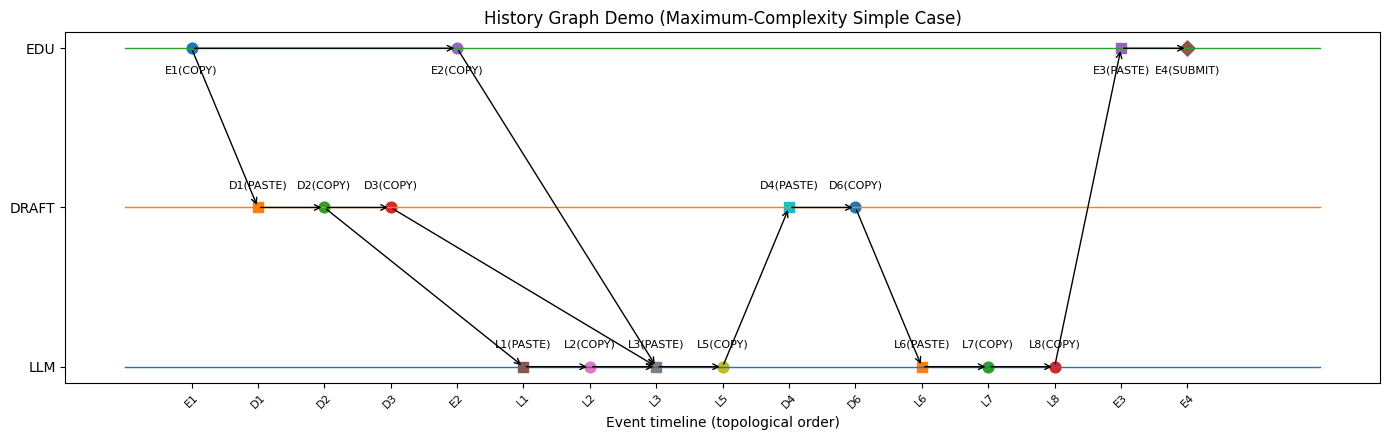

In [5]:
g = HistoryGraph()


def sample_add_node(label: str, parents: List[str], endpoint: EndpointType, action: ActionType, content: str,
                    label_map: Dict[str, str]) -> str:
    n = Node.new(parents=parents, endpoint=endpoint, action=action, content=content, node_id=label)
    # For merge_subgraph-like semantics on single node, use add_node (parents must exist)
    g.add_node(n)
    label_map[label] = n.id
    return n.id


label_id: Dict[str, str] = {}

# Following the earlier narrative:
E1 = sample_add_node("E1", [], "EDU", "COPY", "EDU snippet (problem text)", label_id)
D1 = sample_add_node("D1", [E1], "DRAFT", "PASTE", "Draft imported E1", label_id)
D2 = sample_add_node("D2", [D1], "DRAFT", "COPY", "Draft snapshot after typing", label_id)
L1 = sample_add_node("L1", [D2], "LLM", "PASTE", "LLM receives from D2", label_id)
L2 = sample_add_node("L2", [L1], "LLM", "COPY", "LLM response A", label_id)
D3 = sample_add_node("D3", [D2], "DRAFT", "COPY", "Draft new fragment", label_id)
E2 = sample_add_node("E2", [E1], "EDU", "COPY", "EDU new fragment", label_id)
L3 = sample_add_node("L3", [D3, E2, L2], "LLM", "PASTE", "LLM merges D3+E2+L2", label_id)
L5 = sample_add_node("L5", [L3], "LLM", "COPY", "Partial answer B", label_id)
D4 = sample_add_node("D4", [L5], "DRAFT", "PASTE", "Draft imports B", label_id)
D6 = sample_add_node("D6", [D4], "DRAFT", "COPY", "Draft complete answer C", label_id)
L6 = sample_add_node("L6", [D6], "LLM", "PASTE", "LLM calibrates C", label_id)
L7 = sample_add_node("L7", [L6], "LLM", "COPY", "LLM final calibration", label_id)
L8 = sample_add_node("L8", [L7], "LLM", "COPY", "LLM final for submission", label_id)
E3 = sample_add_node("E3", [L8], "EDU", "PASTE", "EDU receives final", label_id)
E4 = sample_add_node("E4", [E3], "EDU", "SUBMIT", "EDU submits", label_id)

# Plot the whole graph
plot_history_graph(g, title="History Graph Demo (Maximum-Complexity Simple Case)", save_path=None)

# Cipher

## Key Manager

In [6]:
class KeyManager:

    def __init__(self) -> None:
        self._keys: Dict[str, bytes] = {}

    def register_key(self, endpoint_id: str, key: bytes) -> None:
        if not isinstance(key, (bytes, bytearray)) or len(key) == 0:
            raise ValueError("key must be non-empty bytes")
        self._keys[endpoint_id] = bytes(key)

    def get_key(self, endpoint_id: str) -> bytes:
        if endpoint_id not in self._keys:
            raise KeyError(f"no key for endpoint_id={endpoint_id}")
        return self._keys[endpoint_id]

## Encryptor

In [7]:
import os
from cryptography.hazmat.primitives.ciphers.aead import AESGCM


class AESCipher:
    def __init__(self, key_manager):
        self.km = key_manager  # endpoint_id -> 32-byte key

    def encrypt(self, endpoint_id: str, plaintext: bytes) -> dict:
        key = self.km.get_key(endpoint_id)
        aesgcm = AESGCM(key)
        nonce = os.urandom(12)
        ciphertext = aesgcm.encrypt(nonce, plaintext, None)
        return {"nonce_hex": nonce.hex(), "ciphertext_hex": ciphertext.hex()}

    def decrypt(self, endpoint_id: str, nonce_hex: str, ciphertext_hex: str) -> bytes:
        key = self.km.get_key(endpoint_id)
        aesgcm = AESGCM(key)
        nonce = bytes.fromhex(nonce_hex)
        ciphertext = bytes.fromhex(ciphertext_hex)
        return aesgcm.decrypt(nonce, ciphertext, None)

In [8]:
import hashlib
import hmac
import json
from dataclasses import dataclass, field, asdict
from typing import Dict, Any, List, Optional, Literal


def _stable_json(obj: Any) -> str:
    return json.dumps(obj, ensure_ascii=False, sort_keys=True, separators=(",", ":"))


@dataclass
class NodeSummary:
    id: str
    parents: List[str]
    endpoint: EndpointType
    action: Literal["COPY", "PASTE", "SUBMIT"]
    content_hash: str


@dataclass
class PayloadHeader:
    session_id: str
    source_endpoint: EndpointType
    source_endpoint_id: str
    target_endpoint: EndpointType
    target_endpoint_id: str
    version: str = "v0-min"


@dataclass
class PayloadTopology:
    leaf_ids: List[str]
    nodes: List[NodeSummary]


@dataclass
class PayloadBodyEncrypted:
    nonce_hex: str
    ciphertext_hex: str


@dataclass
class FormattedPayload:
    header: PayloadHeader
    body: PayloadBodyEncrypted
    topology: PayloadTopology
    aad: Dict[str, Any] = field(default_factory=dict)
    checksum_hex: Optional[str] = None

    def compute_checksum(self, key: bytes) -> str:
        material = (
                _stable_json(asdict(self.header)).encode("utf-8") +
                _stable_json(asdict(self.body)).encode("utf-8") +
                _stable_json(asdict(self.topology)).encode("utf-8") +
                _stable_json(self.aad).encode("utf-8")
        )
        mac = hmac.new(key, material, hashlib.sha256).hexdigest()
        return mac

    def finalize(self, key_manager: KeyManager) -> None:
        key = key_manager.get_key(self.header.source_endpoint_id)
        self.checksum_hex = self.compute_checksum(key)

    def validate(self, key_manager: KeyManager) -> None:
        if not self.topology.leaf_ids:
            raise ValueError("FP validate: topology.leaf_ids must not be empty")
        ids = {n.id for n in self.topology.nodes}
        if not set(self.topology.leaf_ids).issubset(ids):
            raise ValueError("FP validate: leaf_ids must be subset of nodes")
        for n in self.topology.nodes:
            for p in n.parents:
                if p not in ids:
                    raise ValueError(f"FP validate: node {n.id} has unknown parent {p}")

        if not self.checksum_hex:
            raise ValueError("FP validate: missing checksum")
        expected = self.compute_checksum(key_manager.get_key(self.header.source_endpoint_id))
        if not hmac.compare_digest(expected, self.checksum_hex):
            raise ValueError("FP validate: checksum mismatch")

# Endpoint

## Base Class

In [9]:
class Endpoint:

    def __init__(
            self,
            *,
            endpoint_type: EndpointType,
            endpoint_id: str,
            session_id: str,
            graph: HistoryGraph,
            key_manager: KeyManager,
            cipher: AESCipher,
    ) -> None:
        self.endpoint_type = endpoint_type
        self.endpoint_id = endpoint_id
        self.session_id = session_id
        self.graph = graph
        self.km = key_manager
        self.cipher = cipher

        self.buffer: str = ""
        self.head: Optional[str] = None

    def type(self, text: str, *, replace: bool = False) -> None:
        if replace:
            self.buffer = text
        else:
            self.buffer += text

    def copy(self) -> Node:
        parents: List[str] = [self.head] if self.head else []
        node = Node.new(
            parents=parents,
            endpoint=self.endpoint_type,
            action="COPY",
            content=self.buffer,
        )
        self.graph.add_node(node)
        self.head = node.id
        return node

    def make_payload(
            self,
            *,
            target_endpoint: EndpointType,
            target_endpoint_id: str,
            aad: Dict[str, Any] | None = None,
            include_current_head_as_leaf: bool = True,
    ) -> FormattedPayload:
        if self.head is None:
            raise RuntimeError("make_payload requires a COPY first (no head)")

        sub = self.graph.export_from(self.head)
        nodes: List[NodeSummary] = [
            NodeSummary(
                id=n["id"],
                parents=n["parents"],
                endpoint=n["endpoint"],
                action=n["action"],
                content_hash=n["content_hash"],
            )
            for n in sub["nodes"]
        ]
        leaf_ids = [self.head] if include_current_head_as_leaf else []

        enc = self.cipher.encrypt(self.endpoint_id, self.buffer.encode("utf-8"))

        header = PayloadHeader(
            session_id=self.session_id,
            source_endpoint=self.endpoint_type,
            source_endpoint_id=self.endpoint_id,
            target_endpoint=target_endpoint,
            target_endpoint_id=target_endpoint_id,
        )
        topology = PayloadTopology(leaf_ids=leaf_ids, nodes=nodes)
        body = PayloadBodyEncrypted(**enc)
        fp = FormattedPayload(
            header=header,
            body=body,
            topology=topology,
            aad=aad or {},
        )
        fp.finalize(self.km)
        return fp

    def paste(
            self,
            fp: FormattedPayload,
            *,
            merge_with_current_head: bool = True,
            overwrite_buffer_with_body: bool = True,
            enforce_target_match: bool = True,
    ) -> Node:
        fp.validate(self.km)

        if enforce_target_match:
            if fp.header.target_endpoint != self.endpoint_type or fp.header.target_endpoint_id != self.endpoint_id:
                raise ValueError(
                    f"FP target mismatch: target=({fp.header.target_endpoint},{fp.header.target_endpoint_id}) "
                    f"but here=({self.endpoint_type},{self.endpoint_id})"
                )

        plaintext = self.cipher.decrypt(
            fp.header.source_endpoint_id,
            fp.body.nonce_hex,
            fp.body.ciphertext_hex,
        )
        if overwrite_buffer_with_body:
            self.buffer = plaintext.decode("utf-8")

        import_nodes: List[Node] = []
        for ns in fp.topology.nodes:
            n = Node(
                id=ns.id,
                parents=tuple(ns.parents),
                endpoint=ns.endpoint,
                action=ns.action,
                content_hash=ns.content_hash,
            )
            import_nodes.append(n)
        self.graph.merge_subgraph(import_nodes)

        parents: List[str] = list(fp.topology.leaf_ids)
        if merge_with_current_head and self.head:
            parents.append(self.head)

        node = Node.new(
            parents=parents,
            endpoint=self.endpoint_type,
            action="PASTE",
            content=self.buffer,
        )
        self.graph.add_node(node)
        self.head = node.id
        return node

## Edu Endpoint

In [10]:
class EduEndpoint(Endpoint):
    def __init__(
            self,
            *,
            endpoint_id: str,
            session_id: str,
            graph: HistoryGraph,
            key_manager: KeyManager,
            cipher: AESCipher,
    ) -> None:
        super().__init__(
            endpoint_type="EDU",
            endpoint_id=endpoint_id,
            session_id=session_id,
            graph=graph,
            key_manager=key_manager,
            cipher=cipher,
        )
        self.teacher_requirements: Dict[str, Any] = {}

    def set_teacher_requirements(self, req: Dict[str, Any]) -> None:
        self.teacher_requirements = dict(req or {})

    def submit(self) -> Node:
        parents: List[str] = [self.head] if self.head else []
        node = Node.new(
            parents=parents,
            endpoint="EDU",
            action="SUBMIT",
            content=self.buffer,
        )
        self.graph.add_node(node)
        self.head = node.id
        return node

    def make_payload(
            self,
            *,
            target_endpoint: str,
            target_endpoint_id: str,
            aad: Dict[str, Any] | None = None,
            include_current_head_as_leaf: bool = True,
    ) -> FormattedPayload:
        final_aad = dict(self.teacher_requirements)
        if aad:
            final_aad.update(aad)
        return super().make_payload(
            target_endpoint=target_endpoint,
            target_endpoint_id=target_endpoint_id,
            aad=final_aad,
            include_current_head_as_leaf=include_current_head_as_leaf,
        )

## Draft Endpoint

In [11]:
class DraftEndpoint(Endpoint):
    def __init__(
            self,
            *,
            endpoint_id: str,
            session_id: str,
            graph: HistoryGraph,
            key_manager: KeyManager,
            cipher: AESCipher,
    ) -> None:
        super().__init__(
            endpoint_type="DRAFT",
            endpoint_id=endpoint_id,
            session_id=session_id,
            graph=graph,
            key_manager=key_manager,
            cipher=cipher,
        )

    def make_payload(
            self,
            *,
            target_endpoint: str,
            target_endpoint_id: str,
            aad: Dict[str, Any] | None = None,
            include_current_head_as_leaf: bool = True,
    ) -> FormattedPayload:
        return super().make_payload(
            target_endpoint=target_endpoint,
            target_endpoint_id=target_endpoint_id,
            aad={},
            include_current_head_as_leaf=include_current_head_as_leaf,
        )

## LLM Endpoint

In [12]:
class LlmEndpoint(Endpoint):
    def __init__(
            self,
            *,
            endpoint_id: str,
            session_id: str,
            graph: HistoryGraph,
            key_manager: KeyManager,
            cipher: AESCipher,
    ) -> None:
        super().__init__(
            endpoint_type="LLM",
            endpoint_id=endpoint_id,
            session_id=session_id,
            graph=graph,
            key_manager=key_manager,
            cipher=cipher,
        )
        self.prompt_history: List[str] = []

    def record_prompt(self, prompt: str) -> None:
        self.prompt_history.append(prompt)

    def clear_prompt_history(self) -> None:
        self.prompt_history.clear()

    def make_payload(
            self,
            *,
            target_endpoint: str,
            target_endpoint_id: str,
            aad: Dict[str, Any] | None = None,
            include_current_head_as_leaf: bool = True,
    ) -> FormattedPayload:
        final_aad = {"prompts": list(self.prompt_history)}
        if aad:
            final_aad.update(aad)
        return super().make_payload(
            target_endpoint=target_endpoint,
            target_endpoint_id=target_endpoint_id,
            aad=final_aad,
            include_current_head_as_leaf=include_current_head_as_leaf,
        )

## Example

{
  "nodes": [
    {
      "id": "3d5179ab-0a5d-441f-951f-48ca0ad209c1",
      "parents": [
        "d663ebfd-bbb9-46aa-9030-a379b3495b3d",
        "c92bd7c0-defc-428d-8dc5-004ec0cd47ed"
      ],
      "endpoint": "LLM",
      "action": "PASTE",
      "content_hash": "983a4e5c32886d9106dab0b765427be244243e0618ace938604e431597bfb939"
    },
    {
      "id": "25514143-8998-4a59-ae96-34fced9a0608",
      "parents": [
        "3331b6ab-4503-4e16-a5c9-92a542c12d69",
        "d663ebfd-bbb9-46aa-9030-a379b3495b3d"
      ],
      "endpoint": "DRAFT",
      "action": "PASTE",
      "content_hash": "d7df5f5efc1028a93599838a9dde8e3fcd59c6fa0d2f7fd5fb12958e4cd6ed9e"
    },
    {
      "id": "fce2a2a2-ff31-43df-bcfb-5a0ca7dd866d",
      "parents": [
        "19220cf0-332b-47c7-a42f-faa9fd4745e1"
      ],
      "endpoint": "EDU",
      "action": "SUBMIT",
      "content_hash": "624c76efea9bb4ee33741d052c46b4ca014f2b464809f78612f452b0222a4c77"
    },
    {
      "id": "34a9b7b8-cafe-46b8-b2b6-f04706

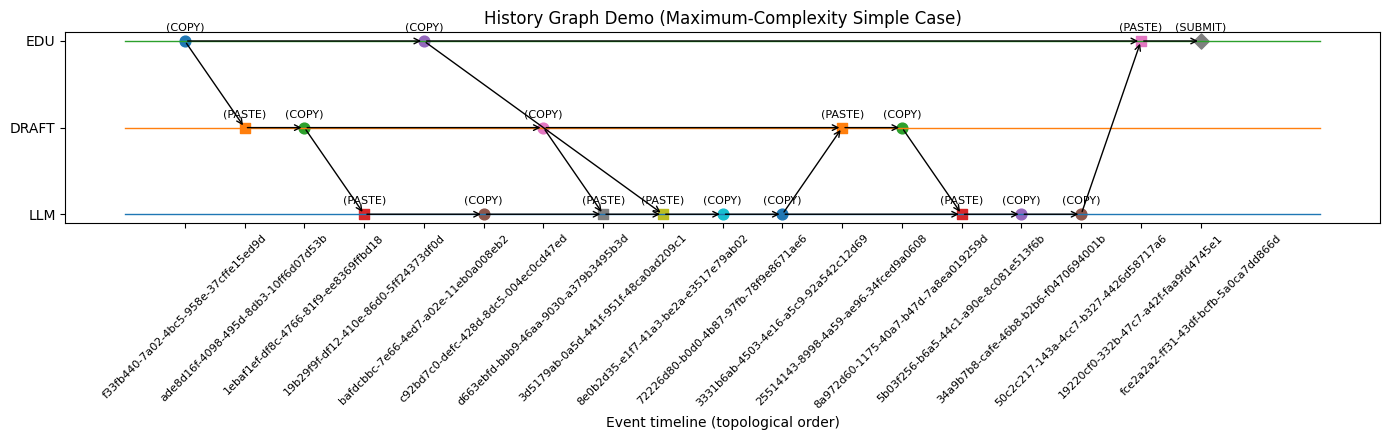

In [26]:
def gen_key(nbytes=32):
    return os.urandom(nbytes)


# ---- 0) Setup keys, cipher, and three independent graphs & endpoints ----
km = KeyManager()
km.register_key("edu-1", gen_key())
km.register_key("draft-1", gen_key())
km.register_key("llm-1", gen_key())

cipher = AESCipher(km)

sid = "session-X"  # session / problem id

edu_graph = HistoryGraph()
draft_graph = HistoryGraph()
llm_graph = HistoryGraph()

EDU = EduEndpoint(endpoint_id="edu-1", session_id=sid, graph=edu_graph, key_manager=km, cipher=cipher)
DRAFT = DraftEndpoint(endpoint_id="draft-1", session_id=sid, graph=draft_graph, key_manager=km, cipher=cipher)
LLM = LlmEndpoint(endpoint_id="llm-1", session_id=sid, graph=llm_graph, key_manager=km, cipher=cipher)

# Some AAD/demo configs
EDU.set_teacher_requirements({"style": "show reasoning steps; avoid LLM boilerplate"})
LLM.record_prompt("Explain step by step.")
LLM.record_prompt("Calibrate final answer to constraints.")


# Helper to send FP from A -> B and paste
def send_and_paste(src, dst):
    fp = src.make_payload(target_endpoint=dst.endpoint_type, target_endpoint_id=dst.endpoint_id)
    return dst.paste(fp)


# ---- 1) EDU → COPY (E1), then paste to DRAFT (D1) ----
EDU.type("Question stem + initial hints.")
E1 = EDU.copy()
D1 = send_and_paste(EDU, DRAFT)

# ---- 2) DRAFT typing only (no node yet) ----
DRAFT.type("\nStudent draft edits... (local typing)")

# ---- 3) EDU typing attempt (still no node) ----
EDU.type("\nEDU-side attempt (not solidified yet)")

# ---- 4) DRAFT → COPY (D2), then paste to LLM (L1) ----
D2 = DRAFT.copy()
L1 = send_and_paste(DRAFT, LLM)

# ---- 5) LLM typing & COPY (L2) ----
LLM.type("\nLLM-side notes; draft of response A.")
L2 = LLM.copy()

# ---- 6) From DRAFT and EDU, COPY (D3, E2), then paste both into LLM ----
DRAFT.type("\nMore draft context.")
D3 = DRAFT.copy()

E2 = EDU.copy()  # solidify EDU-side attempt as a node

# Paste D3 into LLM (merge topology only; keep current buffer)
fp_D3 = DRAFT.make_payload(target_endpoint=LLM.endpoint_type, target_endpoint_id=LLM.endpoint_id)
LLM.paste(fp_D3, overwrite_buffer_with_body=False)

# Paste E2 into LLM (merge topology only; keep current buffer)
fp_E2 = EDU.make_payload(target_endpoint=LLM.endpoint_type, target_endpoint_id=LLM.endpoint_id)
LLM.paste(fp_E2, overwrite_buffer_with_body=False)

# Optional: we already have L2 locally in LLM graph; consolidate to a new copy L3
LLM.type("\nConsolidated understanding after merges.")
L3 = LLM.copy()

# ---- 7) LLM COPY (L5 partial), paste into DRAFT (D4) ----
LLM.type("\nPartial answer B.")
L5 = LLM.copy()
D4 = send_and_paste(LLM, DRAFT)

# ---- 8) DRAFT typing more; COPY (D6); paste to LLM (L6), then LLM COPY (L7, L8) ----
DRAFT.type("\nRefine in draft; ready for final assembly C.")
D6 = DRAFT.copy()
L6 = send_and_paste(DRAFT, LLM)

LLM.type("\nCalibrated final answer (L7).")
L7 = LLM.copy()
LLM.type("\nFinal answer to send back (L8).")
L8 = LLM.copy()

# ---- 9) Paste L8 to EDU (E3), final typing, then SUBMIT (E4) ----
E3 = send_and_paste(LLM, EDU)
EDU.type("\nFinal small edits on EDU before submit.")
E4 = EDU.submit()

# ---- 10) Export EDU history from submission node and pretty-print ----
export = EDU.graph.export_from(E4.id)
print(json.dumps(export, ensure_ascii=False, indent=2))

# Optionally, also show node/edge counts:
# print(f"\nEDU subgraph nodes: {len(export['nodes'])}, edges: {len(export['edges'])}")

# tmp_index = {}
# Ec, Dc, Lc = 1, 1, 1
# for each_node in export["nodes"]:
#     if each_node["endpoint"] == "EDU":
#         tmp_index[each_node["id"]] = f"E{Ec}"
#         Ec += 1
#     elif each_node["endpoint"] == "DRAFT":
#         tmp_index[each_node["id"]] = f"D{Dc}"
#         Dc += 1
#     elif each_node["endpoint"] == "LLM":
#         tmp_index[each_node["id"]] = f"L{Lc}"
#         Lc += 1

# for each_id in tmp_index:
#     if EDU.graph.has_node(each_id):
#         EDU.graph.get_node(each_id).id = tmp_index[each_id]

# plot the graph
plot_history_graph(EDU.graph, title="History Graph Demo (Maximum-Complexity Simple Case)", save_path=None)